In [ ]:
# IPL First Inning Score Prediction Model - Google Colab Version

from google.colab import files
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Upload file manually in Google Colab
uploaded = files.upload()
filename = list(uploaded.keys())[0]
data = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"✅ File '{filename}' uploaded and loaded successfully!\n")


Saving ipl_colab.csv to ipl_colab.csv
✅ File 'ipl_colab.csv' uploaded and loaded successfully!



In [ ]:
# Head, description, info, unique count, data types
print("\n🔹 First 5 rows:")
print(data.head())
print("\n🔹 Dataset Description:")
print(data.describe())
print("\n🔹 Info:")
print(data.info())
print("\n🔹 Number of unique values in each column:")
print(data.nunique())
print("\n🔹 Data types:")
print(data.dtypes)


🔹 First 5 rows:
   mid        date                  venue           batting_team  \
0    1  2008-04-18  M Chinnaswamy Stadium  Kolkata Knight Riders   
1    1  2008-04-18  M Chinnaswamy Stadium  Kolkata Knight Riders   
2    1  2008-04-18  M Chinnaswamy Stadium  Kolkata Knight Riders   
3    1  2008-04-18  M Chinnaswamy Stadium  Kolkata Knight Riders   
4    1  2008-04-18  M Chinnaswamy Stadium  Kolkata Knight Riders   

                  bowling_team      batsman   bowler  runs  wickets  overs  \
0  Royal Challengers Bangalore   SC Ganguly  P Kumar     1        0    0.1   
1  Royal Challengers Bangalore  BB McCullum  P Kumar     1        0    0.2   
2  Royal Challengers Bangalore  BB McCullum  P Kumar     2        0    0.2   
3  Royal Challengers Bangalore  BB McCullum  P Kumar     2        0    0.3   
4  Royal Challengers Bangalore  BB McCullum  P Kumar     2        0    0.4   

   runs_last_5  wickets_last_5  striker  non-striker  total  
0            1               0        0    

In [ ]:

# Drop irrelevant columns
irrelevant = ['mid', 'date', 'venue','batsman', 'bowler', 'striker', 'non-striker']
print(f"\nDropping irrelevant columns: {irrelevant}")
data.drop(columns=irrelevant, inplace=True)
print(f"After removing irrelevant columns: {data.shape}\n")


Dropping irrelevant columns: ['mid', 'date', 'venue', 'batsman', 'bowler', 'striker', 'non-striker']
After removing irrelevant columns: (76014, 8)



In [ ]:
# Keep only consistent teams
teams = ['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
         'Mumbai Indians', 'Kings XI Punjab', 'Royal Challengers Bangalore',
         'Delhi Daredevils', 'Sunrisers Hyderabad']
print("\nKeeping only consistent teams:")
print(teams)
data = data[(data['batting_team'].isin(teams)) & (data['bowling_team'].isin(teams))]


Keeping only consistent teams:
['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals', 'Mumbai Indians', 'Kings XI Punjab', 'Royal Challengers Bangalore', 'Delhi Daredevils', 'Sunrisers Hyderabad']


In [ ]:
# Drop overs < 5
print(f"Before dropping overs < 5: {data.shape}")
data = data[data['overs'] >= 5.0]
print(f"After dropping overs < 5: {data.shape}\n")

Before dropping overs < 5: (53811, 8)
After dropping overs < 5: (40108, 8)



In [ ]:
# Label Encoding batting & bowling team
print("\nEncoding team names...")
le = LabelEncoder()
for col in ['batting_team', 'bowling_team']:
    data[col] = le.fit_transform(data[col])
print("Encoding complete.")


Encoding team names...
Encoding complete.


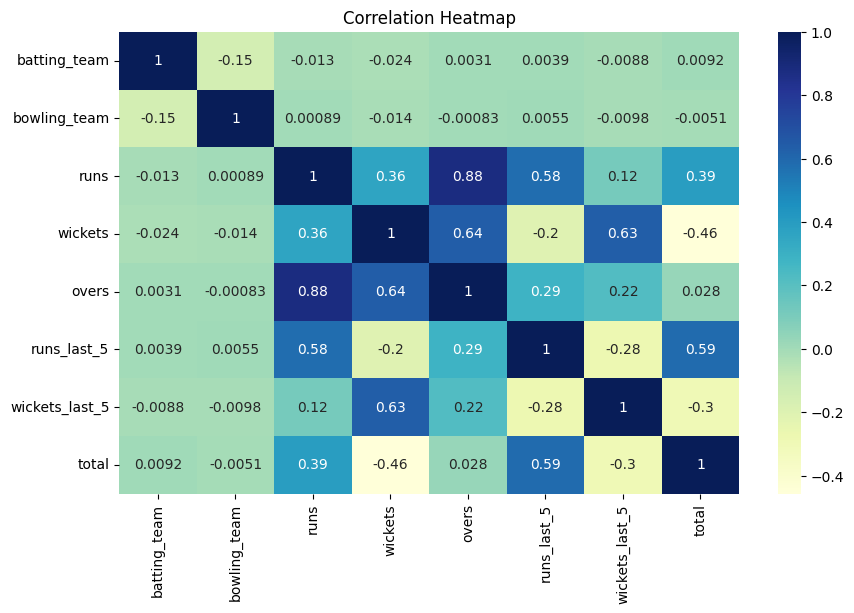

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap")
plt.show()

# One-hot encode teams
ct = ColumnTransformer([('encoder', OneHotEncoder(), [0, 1])], remainder='passthrough')
data_encoded = ct.fit_transform(data)

In [ ]:
# Define column names for encoded data
cols = [
    'batting_team_Chennai Super Kings', 'batting_team_Delhi Daredevils', 'batting_team_Kings XI Punjab',
    'batting_team_Kolkata Knight Riders', 'batting_team_Mumbai Indians', 'batting_team_Rajasthan Royals',
    'batting_team_Royal Challengers Bangalore', 'batting_team_Sunrisers Hyderabad',
    'bowling_team_Chennai Super Kings', 'bowling_team_Delhi Daredevils', 'bowling_team_Kings XI Punjab',
    'bowling_team_Kolkata Knight Riders', 'bowling_team_Mumbai Indians', 'bowling_team_Rajasthan Royals',
    'bowling_team_Royal Challengers Bangalore', 'bowling_team_Sunrisers Hyderabad',
    'runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5', 'total'
]
df = pd.DataFrame(data_encoded, columns=cols)
print("\n🔹 Encoded Data Preview:")
print(df.head())

# Train-test split
X = df.drop('total', axis=1)
y = df['total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}\n")


🔹 Encoded Data Preview:
   batting_team_Chennai Super Kings  batting_team_Delhi Daredevils  \
0                               0.0                            0.0   
1                               0.0                            0.0   
2                               0.0                            0.0   
3                               0.0                            0.0   
4                               0.0                            0.0   

   batting_team_Kings XI Punjab  batting_team_Kolkata Knight Riders  \
0                           0.0                                 1.0   
1                           0.0                                 1.0   
2                           0.0                                 1.0   
3                           0.0                                 1.0   
4                           0.0                                 1.0   

   batting_team_Mumbai Indians  batting_team_Rajasthan Royals  \
0                          0.0                            0.0 

In [ ]:
# Model evaluation function
best_model = None
best_score = -1
best_name = ""
def evaluate_model(model, name):
    global best_model, best_score, best_name
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"\n----- {name} -----")
    print("R2 Score:", r2)
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    if r2 > best_score:
        best_score = r2
        best_model = model
        best_name = name
    return r2

In [ ]:

# Train multiple models
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "LassoCV": LassoCV(),
    "SVR": SVR(),
    "Neural Network": MLPRegressor(max_iter=500)
}

scores = {}
for name, model in models.items():
    score = evaluate_model(model, name)
    scores[name] = score


----- Decision Tree -----
R2 Score: 0.8565408776546035
MAE: 4.053166292695089
MSE: 128.2308339566193
RMSE: 11.323905419801921

----- Linear Regression -----
R2 Score: 0.667865345679383
MAE: 12.95397975017034
MSE: 296.8783233378875
RMSE: 17.23015737995122

----- Random Forest -----
R2 Score: 0.9361991883986065
MAE: 4.423635689354276
MSE: 57.02830984186889
RMSE: 7.551709067613032

----- LassoCV -----
R2 Score: 0.6579689973027167
MAE: 12.987000098936154
MSE: 305.7241672599618
RMSE: 17.48496975290383

----- SVR -----
R2 Score: 0.5825637237240144
MAE: 14.60905529586537
MSE: 373.12511714479365
RMSE: 19.316446804337325

----- Neural Network -----
R2 Score: 0.7713332493982781
MAE: 10.498757296030965
MSE: 204.39361156282718
RMSE: 14.29662937768295


/tmp/ipython-input-1614619971.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette='mako')


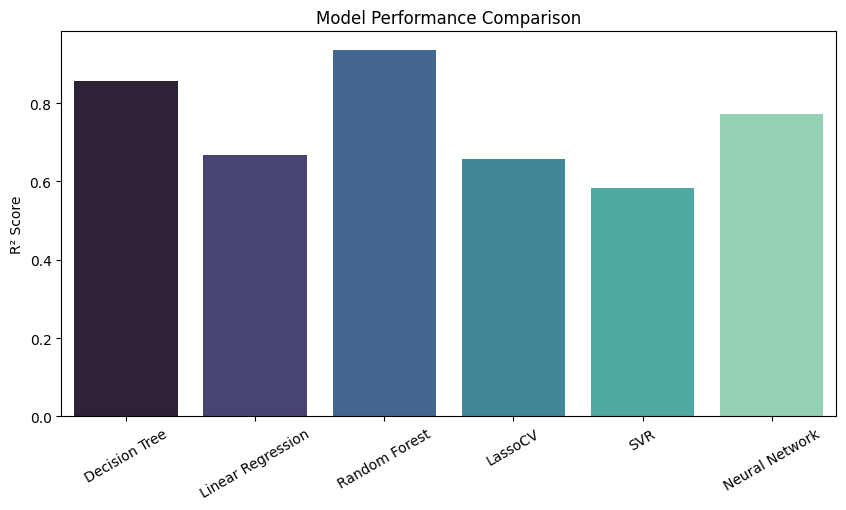


✅ Best Performing Model: Random Forest with R² Score = 0.9362


In [ ]:

# Plot model comparison
plt.figure(figsize=(10,5))
sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette='mako')
plt.ylabel("R² Score")
plt.title("Model Performance Comparison")
plt.xticks(rotation=30)
plt.show()

# Show best model name
print(f"\n✅ Best Performing Model: {best_name} with R² Score = {best_score:.4f}")


✅ Best Performing Model: Random Forest with R² Score = 0.9362


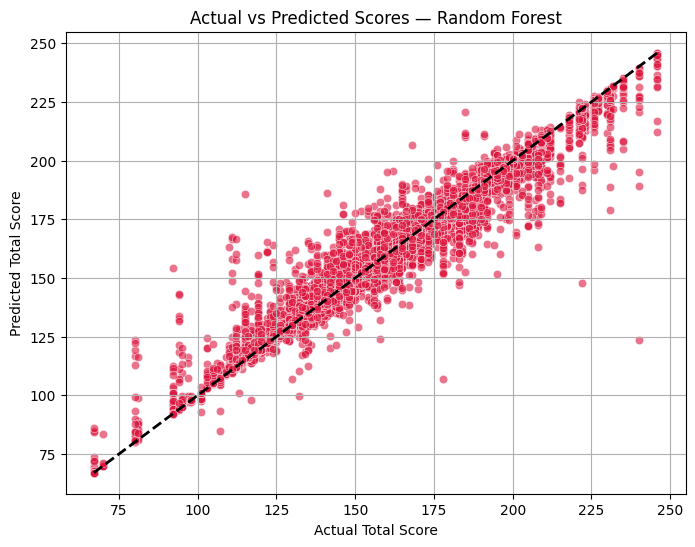

In [ ]:
# Show best model name
print(f"\n✅ Best Performing Model: {best_name} with R² Score = {best_score:.4f}")

# Visualize Actual vs Predicted for best model
y_pred_best = best_model.predict(X_test)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6, color='crimson')
plt.xlabel("Actual Total Score")
plt.ylabel("Predicted Total Score")
plt.title(f"Actual vs Predicted Scores — {best_name}")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.grid(True)
plt.show()


In [ ]:
# IPL First Inning Score Prediction Model - Google Colab Version

# (Imports and everything else remains unchanged up to prediction function)

# Prediction function
def predict_score(batting_team, bowling_team, runs, wickets, overs, runs_last_5, wickets_last_5, model):
    teams_order = [
        'Chennai Super Kings', 'Delhi Daredevils', 'Kings XI Punjab',
        'Kolkata Knight Riders', 'Mumbai Indians', 'Rajasthan Royals',
        'Royal Challengers Bangalore', 'Sunrisers Hyderabad']

    row = [0]*16 + [runs, wickets, overs, runs_last_5, wickets_last_5]
    row[teams_order.index(batting_team)] = 1
    row[8 + teams_order.index(bowling_team)] = 1

    input_df = pd.DataFrame([row], columns=X.columns)
    return int(round(model.predict(input_df)[0]))

# Example predictions — broken into individual blocks for clarity
print("\n🔹 Test Prediction 1")
pred1 = predict_score('Delhi Daredevils', 'Chennai Super Kings', 68, 3, 10.2, 29, 1, model=best_model)
print(f"Delhi vs CSK — Predicted Score: {pred1}")

print("\n🔹 Test Prediction 2")
pred2 = predict_score('Mumbai Indians', 'Kings XI Punjab', 113, 2, 12.3, 55, 0, model=best_model)
print(f"MI vs KXIP — Predicted Score: {pred2}")

print("\n🔹 Test Prediction 3")
pred3 = predict_score('Kings XI Punjab', 'Rajasthan Royals', 118, 1, 14.0, 45, 0, model=best_model)
print(f"KXIP vs RR — Predicted Score: {pred3}")

print("\n🔹 Test Prediction 4")
pred4 = predict_score('Kolkata Knight Riders', 'Chennai Super Kings', 150, 4, 18.0, 57, 1, model=best_model)
print(f"KKR vs CSK — Predicted Score: {pred4}")

print("\n🔹 Test Prediction 5")
pred5 = predict_score('Delhi Daredevils', 'Mumbai Indians', 96, 8, 18.0, 18, 4, model=best_model)
print(f"Delhi vs MI — Predicted Score: {pred5}")

print("\n🔹 Test Prediction 6")
pred6 = predict_score('Kings XI Punjab', 'Chennai Super Kings', 129, 6, 18.0, 34, 2, model=best_model)
print(f"KXIP vs CSK — Predicted Score: {pred6}")




🔹 Test Prediction 1
Delhi vs CSK — Predicted Score: 149

🔹 Test Prediction 2
MI vs KXIP — Predicted Score: 186

🔹 Test Prediction 3
KXIP vs RR — Predicted Score: 188

🔹 Test Prediction 4
KKR vs CSK — Predicted Score: 174

🔹 Test Prediction 5
Delhi vs MI — Predicted Score: 106

🔹 Test Prediction 6
KXIP vs CSK — Predicted Score: 147
